In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt


import sys
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from local_utils import *

from turing.three_nodes_circuits import create_circuit_3954
from pde_solvers.cn import *

from scipy.optimize import fsolve
from scipy.linalg import eigvals

In [2]:
from scipy.optimize import minimize

def rosenbrock(x1, x2, a=1, b=5):
    return (a-x1)**2 + b*(x2 - x1**2)**2

def alienor_components(epsilon, l1, bounds, ):
    """
    
    Args:
          epsilon (float): The accuracy of the estimates.
          l1 (float): Lipschitz constant
          bounds (list of tuples):
          bounds like [a_i, b_i], for each variables separatly.
          
          
    """
    n = len(bounds) 
    assert n >= 2, "The method expects two or more vairbales."
    assert np.all([len(item) == 2 
                   for item in bounds]), "bounds must be tuple of (a_i,b_i)"
    
    alpha = epsilon/(2*l1*np.sqrt(n-1))
    alphas = np.ones(n)
    
    def get_h_i(a,b,alpha):
        def h_i(t):
            return (a-b)*np.cos(alpha*t)/2 + (a+b)/2
        return h_i
    a,b = bounds[0]
    h_i = get_h_i(a,b, 1)
    h_list = [h_i]
    for i in range(1, n):
        # [a_i, b_i]
        a,b = bounds[i-1]
        # (pi/alpha)^(i-1) (b_i - a_i)
        alphas[i] = np.pi*alphas[i-1]*(b-a)/alpha
        # h_i = (a_i - b_i)cos(alpha_i theta)/2 +  (a_i + b_i)/2
        a,b = bounds[i]
        h_i = get_h_i(a,b, alphas[i])
        h_list.append(h_i)
        
        
    # l2 or Lipschitz constant of the aliemor h functions
    l2 = np.linalg.norm([(d[1]-d[0])**2 * a**2 for d,a in zip(bounds,alphas) ])/2
    theta_max = np.pi/alphas[0]
    return alpha, alphas, l2, h_list, theta_max

def minim(epsilon, l1, bounds, func, maxiter=10,method="Nelder-Mead"):
    alpha, alphas, l2, h_list, theta_max = alienor_components(epsilon, l1, bounds)
    k = 1
    L = l1 * l2
    
    theta = theta_max/2#np.pi/(2*alphas[0])  
    bounds=[(0, theta_max)]
    
    theta_epsilon = theta
    f = lambda t: func(*[ h(t) for h in h_list])
    
    f_epsilon = f(theta_epsilon)
    F_epsilon = f_epsilon - L*theta_max/2
    def single_F_k(f_theta, theta):
        def F_k(t):
            return f_theta - L*np.abs(theta - t)
        return F_k
    
    def get_F_k_func(F_k_list):
        def F_k_func(t):
            return np.max([f_i(t) for f_i in F_k_list])
        return F_k_func
    
    def get_F_k_func_vec(f_epsilon_arr, theta_arr):
        def F_k_func(t):
            return np.max(f_epsilon_arr - L*np.abs(theta_arr - t))
        return F_k_func
            
    #theta_list = [theta]       
    #F_k_list = [single_F_k(f_epsilon, theta)]        
    #F_k_func = get_F_k_func(F_k_list)
    theta_arr = np.array([theta])
    f_epsilon_arr = np.array([f_epsilon]) 
    F_k_func = get_F_k_func_vec(f_epsilon_arr, theta_arr)
    res = minimize(F_k_func, x0=0,hess=lambda x: np.zeros((x.shape[0], x.shape[0])),
                   bounds=bounds,  method=method)    
    theta = res['x'][0]        
    f_theta  =  f(theta)
    while k < maxiter:
        if f_epsilon - F_epsilon <= epsilon/2:            
            return (k, theta_arr, f_epsilon_arr, F_epsilon, F_k_func, 
                    theta_epsilon, f_epsilon, "")
        
        if f_theta < f_epsilon:
            f_epsilon = f_theta
            theta_epsilon = theta
        
        #theta_list += [theta]
        #F_k_list += [single_F_k(f_theta, theta)]
        #F_k_func = get_F_k_func(F_k_list)
        theta_arr = np.concatenate([theta_arr, [theta]])
        f_epsilon_arr = np.concatenate([f_epsilon_arr, [f_epsilon]]) 
        F_k_func = get_F_k_func_vec(f_epsilon_arr, theta_arr)
        res = minimize(F_k_func, x0=0,hess=lambda x: np.zeros((x.shape[0], x.shape[0])),
                       bounds=bounds,  method=method)
        
        theta = res['x'][0] 
        f_theta  =  f(theta)
        F_epsilon = res['fun']
        k += 1    
    return (k, theta_arr, f_epsilon_arr, F_epsilon, F_k_func, 
                    theta_epsilon, f_epsilon, f"max iteration '{maxiter}' is reached")

def alienor_components2(epsilon, l1, bounds):
    """
    
    Args:
          epsilon (float): The accuracy of the estimates.
          l1 (float): Lipschitz constant
          bounds (list of tuples):
          bounds like [a_i, b_i], for each variables separatly.
          
          
    """
    n = len(bounds) 
    assert n >= 2, "The method expects two or more vairbales."
    assert np.all([len(item) == 2 
                   for item in bounds]), "bounds must be tuple of (a_i,b_i)"
    
    alpha = epsilon/(2*l1*np.sqrt(n-1))
    alphas = np.ones(n)
    
    def get_h_i(a,b,alpha):
        def h_i(t):
            return (a-b)*np.cos(alpha*t)/2 + (a+b)/2
        return h_i
    a,b = bounds[0]
    h_i = get_h_i(a,b,1)
    h_list = [h_i]
    for i in range(1, n):
        # [a_i, b_i]
        a,b = bounds[i]
        # alphas[i-1] (alpha/pi) / (|b_i| + |a_i|)
        alphas[i] = alpha*alphas[i-1]/(np.pi*(np.abs(b)+np.abs(a)))
        # h_i = (a_i - b_i)cos(alpha_i theta)/2 +  (a_i + b_i)/2         
        h_i = h_i = get_h_i(a,b,alphas[i])#
        h_list.append(h_i)        
        
        
    # l2 or Lipschitz constant of the aliemor h functions
    l2 = np.linalg.norm([(np.abs(d[1])+np.abs(d[0]))**2 * a**2 for d,a in zip(bounds,alphas) ])/2
    #
    theta_max = np.pi/alphas[-1]    
    return alpha, alphas, l2, h_list, theta_max

def minim_2(epsilon, l1, bounds, func, maxiter=10000):
    alpha, alphas, l2, h_list, theta_max = alienor_components2(epsilon, l1, bounds)
    k = 1
    L = l1 * l2
    theta = epsilon / L    
    theta_epsilon = theta
    f = lambda t: func(*[ h(t) for h in h_list])
    f_epsilon = f_theta = f(theta_epsilon)
    while k < maxiter:
        if theta > np.pi/alphas[-1]:            
            return k, theta,theta_epsilon, f_epsilon, ""
        
        theta = theta + (epsilon + f_theta - f_epsilon)/ L
        f_theta  =  f(theta)
        if f_theta < f_epsilon:
            f_epsilon = f_theta
            theta_epsilon = theta
        k += 1    
    return k, theta,theta_epsilon, f_epsilon, f"max iteration '{maxiter}' is reached"

In [12]:
bounds = [(0,2), (0,2)]
epsilon = 1e-2
alpha, alphas, l, h_list, theta_max = alienor_components(epsilon, 1, bounds)
# alienor_Z_func = lambda theta: rosenbrock(h_list[0](theta), h_list[1](theta))
# print(alpha, alphas, l, theta_max)
print("-----------")
(k, theta_arr, f_epsilon_arr, F_epsilon, F_k_func, 
theta_epsilon, f_epsilon, msg) =  minim(epsilon, 1, bounds, rosenbrock, 10000,
                                        method="L-BFGS-B")
print(k, F_epsilon, theta_epsilon, f_epsilon, msg)

-----------
10000 -302.7684557743562 1.513838503891211 0.0032547311268236886 max iteration '10000' is reached


In [13]:
print(h_list[0](theta_epsilon), h_list[1](theta_epsilon))
print(rosenbrock(h_list[0](theta_epsilon), h_list[1](theta_epsilon)))

0.9430729691351166 0.8890118680756015
0.0032547311268236886


In [11]:
print(h_list[0](theta_epsilon), h_list[1](theta_epsilon))
print(rosenbrock(h_list[0](theta_epsilon), h_list[1](theta_epsilon)))

1.0705130228237563 1.1476329238687182
0.005239340821618992


In [ ]:
[f_i(0) for f_i in F_k_list]

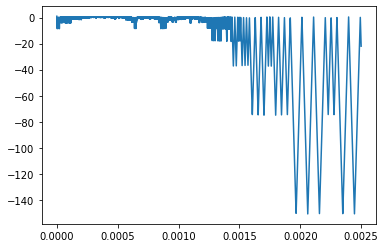

In [394]:
ts =  np.linspace(0, np.pi/alphas[-1], 5000)
plt.plot(ts, [F_k_func(t) for t in ts])

In [200]:
bounds = [(0,2), (0,2)]
alpha, alphas, l2, h_list, theta_max = alienor_components(.01, 1, bounds)
alienor_Z_func = lambda theta: rosenbrock(h_list[0](theta), h_list[1](theta))
alpha, alphas, l2, theta_max

(0.005,
 array([1.00000000e+00, 1.25663706e+03]),
 3158273.408349228,
 3.141592653589793)

In [13]:
bounds = [(0,2), (0,2)]
alpha, alphas, l2, h_list2, theta_max2 = alienor_components2(.001, 1, bounds)
alienor_Z2_func = lambda theta: rosenbrock(h_list2[0](theta), h_list2[1](theta))
alpha, alphas, l2, theta_max2

(0.0005, array([1.00000000e+00, 7.95774715e-05]), 2.0, 39478.417604357426)

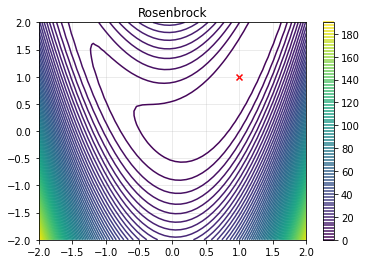

In [31]:
x1 = np.linspace(-2, bounds[0][1])
x2 = np.linspace(-2, bounds[1][1])

X1, X2 = np.meshgrid(x1, x2)

Z = rosenbrock(X1, X2)

plt.contour(X1, X2, Z, 80); plt.colorbar();
plt.scatter(1,1,marker='x', c='red');plt.grid(alpha=.3)
plt.title("Rosenbrock");plt.show()

In [201]:
theta = np.linspace(0,theta_max, 2000)
x1_theta, x2_theta = h_list[0](theta), h_list[1](theta)
alienor_z = rosenbrock(x1_theta, x2_theta)

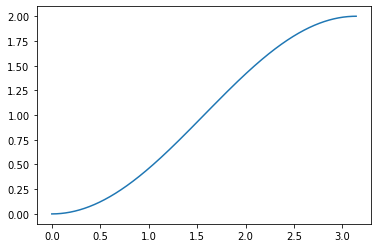

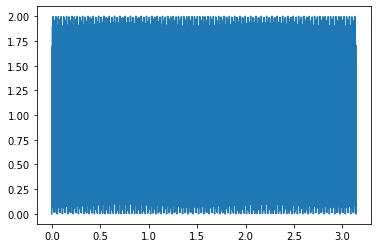

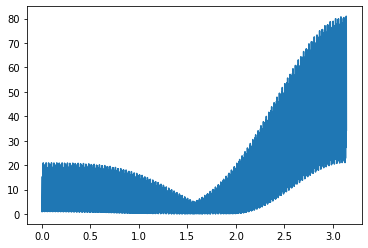

In [202]:
plt.plot(theta, x1_theta);plt.show()
plt.plot(theta, x2_theta);plt.show()
plt.plot(theta, alienor_z);plt.show()

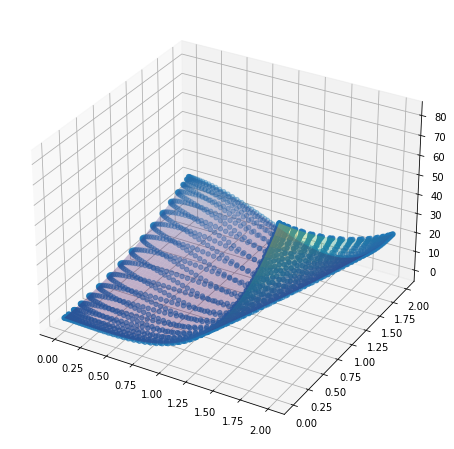

In [203]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(x1_theta, x2_theta, alienor_z,  cmap='binary')
#ax.plot3D(x1_theta2, x2_theta2, alienor_z2, 'gray')
#ax.contour3D(X1, X2, Z, 50, cmap='binary')

ax.plot_surface(X1, X2, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', alpha=.3)

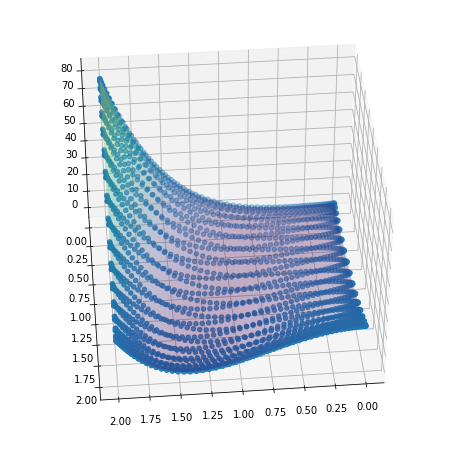

In [204]:
ax.view_init(40, 85)
fig

In [197]:
from scipy.optimize import minimize
minimize(lambda args:rosenbrock(args[0], args[1]), [0,0], bounds = [(0, 2), (0, 2)])

      fun: 8.40971505196569e-14
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.16218927e-08, -1.47426294e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 36
      nit: 10
     njev: 12
   status: 0
  success: True
        x: array([0.99999971, 0.99999941])

In [207]:
res = minimize(alienor_Z_func, .5, bounds = [(0, theta_max)])
res

      fun: 0.7700342621965812
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00014385])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 18
      nit: 2
     njev: 9
   status: 0
  success: True
        x: array([0.50013977])

In [206]:
print(h_list[0](res['x']), h_list[1](res['x']))
print(rosenbrock(h_list[0](res['x']), h_list[1](res['x'])))

[0.16916608] [0.02892402]
[0.69028547]


In [118]:
theta2 = np.linspace(0,theta_max2, 1000)
x1_theta2, x2_theta2 = h_list2[0](theta2), h_list2[1](theta2)
alienor_z2 = rosenbrock(x1_theta2, x2_theta2)

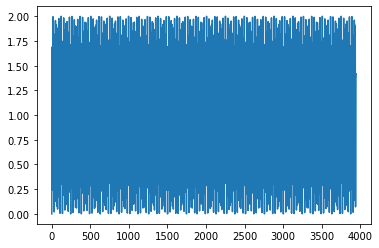

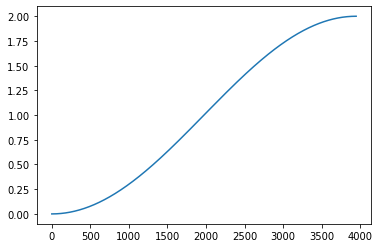

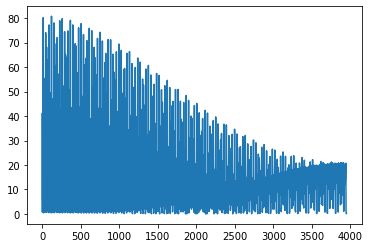

In [119]:
plt.plot(theta2, x1_theta2);plt.show()
plt.plot(theta2, x2_theta2);plt.show()
plt.plot(theta2, alienor_z2);plt.show()

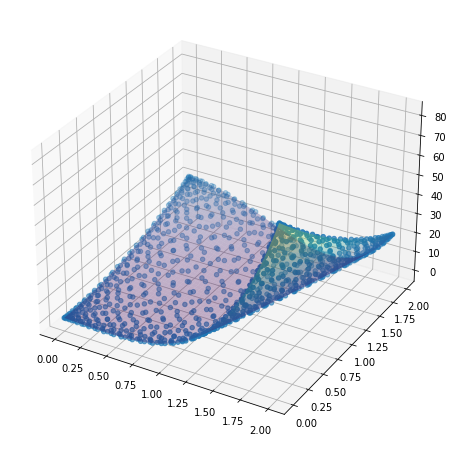

In [138]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(x1_theta2, x2_theta2, alienor_z2,  cmap='binary')
#ax.plot3D(x1_theta2, x2_theta2, alienor_z2, 'gray')
#ax.contour3D(X1, X2, Z, 50, cmap='binary')

ax.plot_surface(X1, X2, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', alpha=.3)

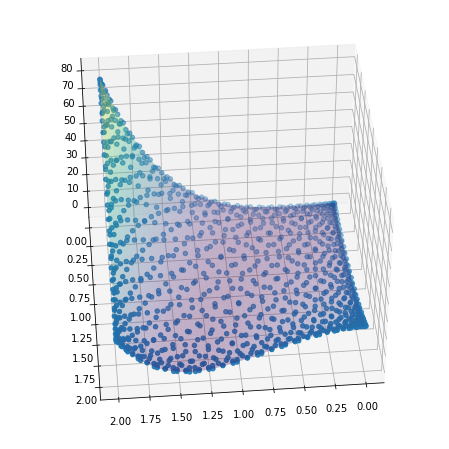

In [139]:
ax.view_init(40, 85)
fig

In [172]:
res2 = minimize(alienor_Z2_func, theta_max2/2, bounds = [(0, theta_max2)])
res2

      fun: 7.06937081967464e-06
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.44847808e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 30
      nit: 7
     njev: 15
   status: 0
  success: True
        x: array([1980.7767631])

In [199]:
print(h_list2[0](res2['x']), h_list2[1](res2['x']))
print(rosenbrock(h_list2[0](res2['x']), h_list2[1](res2['x'])))

[1.00259501] [1.00545571]
[7.06937082e-06]


In [23]:
bounds = [(0,2), (0,2)]
epsilon = 1e-5
alpha, alphas, l2, h_list2, theta_max2 = alienor_components2(epsilon, 1, bounds)
alienor_Z2_func = lambda theta: rosenbrock(h_list2[0](theta), h_list2[1](theta))
#print(alpha, alphas, l2, theta_max2)
k2,theta2, theta_epsilon2, f_epsilon2, msg =  minim_2(
    epsilon, 1, bounds, rosenbrock, 1e7)
print(k2,theta2, theta_epsilon2, f_epsilon2, msg)

1122005 3947970.337683964 1995013.4451284062 6.967097749711418e-05 


In [24]:
print(h_list2[0](theta_epsilon2), h_list2[1](theta_epsilon2))
print(rosenbrock(h_list2[0](theta_epsilon2), h_list2[1](theta_epsilon2)))

1.0083375491903666 1.0167841417038874
6.967097749711418e-05


In [ ]:
fun: 8.40971505196569e-14
hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
jac: array([ 3.16218927e-08, -1.47426294e-07])
message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
nfev: 36
nit: 10
njev: 12
status: 0
success: True
x: array([0.99999971, 0.99999941])

In [240]:
bounds = [(0,2), (0,2)]
epsilon = 1e-1
alpha, alphas, l, h_list, theta_max = alienor_components(epsilon, 1, bounds)
alienor_Z_func = lambda theta: rosenbrock(h_list[0](theta), h_list[1](theta))
print(alpha, alphas, l, theta_max)
(k, theta_list, F_epsilon, 
theta_epsilon, f_epsilon, msg) =  minim(epsilon, 1, bounds, rosenbrock, 10)
print(k, theta_list, F_epsilon, 
theta_epsilon, f_epsilon, msg)

0.05 [  1.         125.66370614] 31582.734146811687 3.141592653589793


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()